In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
!pip install opencv-python
# !pip install tensorflow[and-cuda]

In [3]:

def Knn(x_test_df, train_df):
    from sklearn.neighbors import KNeighborsClassifier as KNN
    import numpy as np
    from skimage.transform import resize
    from sklearn.svm import SVC
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import NearestCentroid
    from myLabeling import myLabeling

    #画像を共通のサイズにリサイズ
    target_size = (71, 71)
    resized_images = []
    for img in train_df['waferMap']:
        resized_img = resize(img, target_size, anti_aliasing=True)
        resized_images.append(resized_img)

    #NumPy配列に変換
    X_train = np.array(resized_images)
    y_train = np.array(train_df['failureType'])

    #PCA次元削減
    pca = PCA(n_components=350)
    X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))

    # SVM作成と訓練
    knn = KNN(n_neighbors=8, n_jobs=-1)
    knn.fit(X_train_pca, y_train)

    #テストデータで予測
    resized_images_test = []
    for img in x_test_df['waferMap']:
        resized_img_test = resize(img, target_size, anti_aliasing=True)
        resized_images_test.append(resized_img_test)

    X_test = np.array(resized_images_test)
    X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

    y_pred = knn.predict(X_test_pca)
    return y_pred

def solution(x_test_df, train_df):
    y_pred = Knn(x_test_df, train_df)
    return pd.DataFrame({'failureType': y_pred}, index=x_test_df.index)

In [8]:
# %%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))

    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

平均精度：81.00%


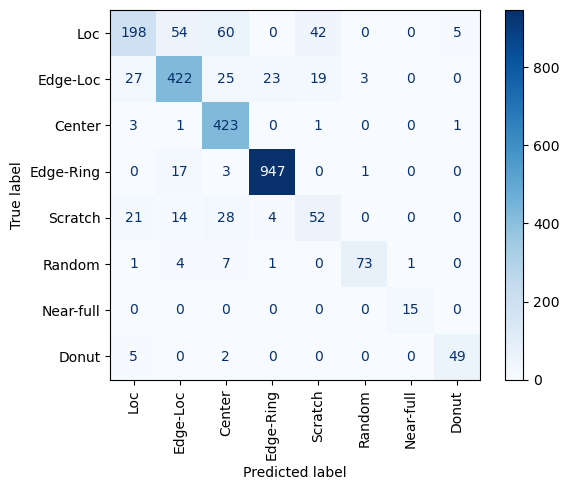

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 参考：https://qiita.com/wakame1367/items/5420ac91702edf993124
# 恐らく、こんな意味↓ ドキュメント見てもよくわからんかった。
# y_pred: 予測したfailureType, y_true: 正解のfailureType
labels = df['failureType'].unique()
cm = confusion_matrix(y_pred=user_result_df['failureType'], y_true=y_test_df['failureType'], labels=labels)
# display_labels: 集計して表示するラベル。
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)

cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
